In [1]:
import csv
import json
import os
import random

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer as CV
import nltk
import kenlm
import re

from scipy.stats import ttest_ind, ttest_rel

import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
sfp_data = pd.read_csv("../sample_data/sfp_data_v4.csv")

In [3]:
td_data = pd.read_csv("../sample_data/td_data_v4.csv")

In [4]:
sfp_authors = sfp_data['author'].unique()
td_authors = td_data['author'].unique()

sfp_posts = sfp_data.loc[sfp_data['subreddit'] == 'SandersForPresident']
td_posts = td_data.loc[td_data['subreddit'] == 'The_Donald']

sfp_min_times = [min(sfp_posts.loc[sfp_posts['author'] == auth]['created_utc']) for auth in sfp_authors]
td_min_times = [min(td_posts.loc[td_posts['author'] == auth]['created_utc']) for auth in td_authors]

In [5]:
print(sfp_data.shape)
print(td_data.shape)
print(len(sfp_authors))
print(len(td_authors))
print(sfp_posts.shape)
print(td_posts.shape)

(4868749, 5)
(4003940, 5)
2000
2000
(78037, 5)
(55521, 5)


In [6]:
min_overall_time = 1420131600
max_overall_time = 1464753600

In [7]:
sfp_politics = sfp_data.loc[sfp_data['subreddit'] == 'politics']
td_politics = td_data.loc[td_data['subreddit'] == 'politics']

sfp_politics = sfp_politics.loc[sfp_politics['created_utc'] >= min_overall_time]
sfp_politics = sfp_politics.loc[sfp_politics['created_utc'] < max_overall_time]

td_politics = td_politics.loc[td_politics['created_utc'] >= min_overall_time]
td_politics = td_politics.loc[td_politics['created_utc'] < max_overall_time]

print(sfp_politics.shape)
print(td_politics.shape)

(131076, 5)
(42352, 5)


In [8]:
sfp_politics_before = pd.DataFrame([], columns = sfp_politics.columns)
sfp_politics_after = pd.DataFrame([], columns = sfp_politics.columns)

for i in range(len(sfp_authors)):
    curr_auth_posts = sfp_politics.loc[sfp_politics['author'] == sfp_authors[i]]
    
    if len(curr_auth_posts) > 0:
        sfp_politics_before = \
sfp_politics_before.append(curr_auth_posts.loc[curr_auth_posts['created_utc'] < sfp_min_times[i]])
        
        sfp_politics_after = \
sfp_politics_after.append(curr_auth_posts.loc[curr_auth_posts['created_utc'] > sfp_min_times[i]])
    

In [9]:
td_politics_before = pd.DataFrame([], columns = td_politics.columns)
td_politics_after = pd.DataFrame([], columns = td_politics.columns)

for i in range(len(td_authors)):
    curr_auth_posts = td_politics.loc[td_politics['author'] == td_authors[i]]
    
    if len(curr_auth_posts) > 0:
        td_politics_before = \
td_politics_before.append(curr_auth_posts.loc[curr_auth_posts['created_utc'] < td_min_times[i]])
        
        td_politics_after = \
td_politics_after.append(curr_auth_posts.loc[curr_auth_posts['created_utc'] > td_min_times[i]])
    

In [10]:
sfp_politics_before_text = sfp_politics_before.loc[sfp_politics_before['body'].notna()]['body'].values
sfp_politics_after_text = sfp_politics_after.loc[sfp_politics_after['body'].notna()]['body'].values

td_politics_before_text = td_politics_before.loc[td_politics_before['body'].notna()]['body'].values
td_politics_after_text = td_politics_after.loc[td_politics_after['body'].notna()]['body'].values

sfp_posts_text = sfp_posts.loc[sfp_posts['body'].notna()]['body'].values
td_posts_text = td_posts.loc[td_posts['body'].notna()]['body'].values

In [11]:
def tokenize_data(data, deleted_str = '[deleted]', removed_str = '[removed]', verbose=True):
    if(verbose):
        print("Number of entries in original dataset: " + str(len(data)))
    data1 = [i for i in data if 'thank you for participating' not in i.lower()]
    if(verbose):
        print("Number of moderator posts removed from dataset: " + str(len([i for i in data if 'thank you for participating' in i.lower()])))
    data1 = [i for i in data1 if i != deleted_str and i != removed_str]
    if(verbose):
        print("Number of user-deleted posts removed from dataset: " + str(len([i for i in data if i == deleted_str])))
        print("Number of mod/admin-deleted posts removed from dataset: " + str(len([i for i in data if i == removed_str])))
    
        print("Number of entries in modified dataset: " + str(len(data1)))
    
    # removing hyperlinks
        print("Number of comments with a hyperlink in modified dataset: " + str(len([i for i in data1 if "http" in i])))
    
    data1 = [re.sub(r'https?:\/\/[\S]+', ' ', i, flags=re.MULTILINE) for i in data1]
    
    # common escape sequences
    data1 = [re.sub(r'\n', '', i) for i in data1]
    data1 = [re.sub(r'&gt;', '', i) for i in data1]
    
    # convert to lowercase
    data1 = [i.lower() for i in data1]
    
    # keep user and subreddit tags
    if(verbose):
        print("Number of comments that mention a user in the modified dataset: " + str(len([i for i in data1 if "/u/" in i])))
        print("Number of comments that mention a subreddit in the modified dataset: " + str(len([i for i in data1 if "/r/" in i])))
    
    data1 = [re.sub(r'/u/', '_user_', i) for i in data1]
    data1 = [re.sub(r'/r/', '_subreddit_', i) for i in data1]
    
    data_tokenized = [re.findall(r'\w+', i.lower()) for i in data1]
    
    if(verbose):
        print("Number of total tokens: " + str(sum([len(d) for d in data_tokenized])))
    
    return [(' '.join(i) + '\n') for i in data_tokenized]


In [12]:
text_arrs = [sfp_politics_before_text,
             sfp_politics_after_text,
             td_politics_before_text,
             td_politics_after_text,
             sfp_posts_text,
             td_posts_text]

test_arrs = []

for i in range(len(text_arrs)):
    lm_test_arr = tokenize_data(text_arrs[i])
    print()
    test_arrs.append(lm_test_arr)

Number of entries in original dataset: 28504
Number of moderator posts removed from dataset: 0
Number of user-deleted posts removed from dataset: 0
Number of mod/admin-deleted posts removed from dataset: 0
Number of entries in modified dataset: 28504
Number of comments with a hyperlink in modified dataset: 1523
Number of comments that mention a user in the modified dataset: 79
Number of comments that mention a subreddit in the modified dataset: 232
Number of total tokens: 1226203

Number of entries in original dataset: 102572
Number of moderator posts removed from dataset: 52
Number of user-deleted posts removed from dataset: 1
Number of mod/admin-deleted posts removed from dataset: 0
Number of entries in modified dataset: 102519
Number of comments with a hyperlink in modified dataset: 6326
Number of comments that mention a user in the modified dataset: 201
Number of comments that mention a subreddit in the modified dataset: 731
Number of total tokens: 4335851

Number of entries in ori

In [13]:
for i in range(len(test_arrs)):
    print(len(test_arrs[i]))
    print(test_arrs[i][:10])
    print("\n\n")

28504
['what state do you live in\n', 'awesome\n', 'a link to the actual bill\n', 'can you provide a source proving that planned parenthood is using donations to some kind of real benefit how are they getting around the law are they not just donating to the scientific community from the article it turns out nucatola wasn t discussing the illegal black market sale of fetal organs but instead the perfectly legal donation of the organs to biomedical research laboratories that use the organs to help save lives the price range of the organs described by nucatola is in reality the reimbursed expenses accrued in the delivery of the specimens\n', 'which was a total misrepresentation of the question he brought up reassignment himself and then went on to describe what the military does standard garbage response\n', 'what if hillary gets the nomination despite the popular vote being solidly behind sanders if the democratic base is convinced the party went against the will of the people in favor o

In [14]:
for i in range(len(test_arrs)):
    print(len(test_arrs[i]))

28504
102519
23854
18497
78036
55512


In [15]:
filenames = ['politics_train.arpa',
             'sfp_politics_before.arpa', 
             'sfp_politics_after.arpa',
             'td_politics_before.arpa',
             'td_politics_after.arpa',
             'sfp_posts.arpa',
             'td_posts.arpa']

In [16]:
language_models = []

for i in range(len(filenames)):
    curr_lm = os.path.join(os.path.dirname('Language models.ipynb'), '..', 'language_models', filenames[i])
    curr_model = kenlm.LanguageModel(curr_lm)
    print('{0}-gram model'.format(curr_model.order))
    language_models.append(curr_model)

2-gram model
2-gram model
2-gram model
2-gram model
2-gram model
2-gram model
2-gram model


In [19]:
def calculate_values_ind(text1, text2, scoring_func, divide_by_len=True):
    if divide_by_len:
        scores1 = [scoring_func(s)/len(re.findall(r'\w+', s)) for s in text1 if len(re.findall(r'\w+', s)) > 0]
        scores2 = [scoring_func(s)/len(re.findall(r'\w+', s)) for s in text2 if len(re.findall(r'\w+', s)) > 0]
    else:
        scores1 = [scoring_func(s) for s in text1]
        scores2 = [scoring_func(s) for s in text2]

    mean1 = sum(scores1)/len(scores1)
    mean2 = sum(scores2)/len(scores2)
    print(mean1)
    print(mean2)
    print()
    
    print(ttest_ind(scores1, scores2))

## Use a t-test

In [20]:
# sfp_politics_before, td_politics_before, sfp_politics_before
calculate_values_ind(test_arrs[0], test_arrs[2], language_models[1].score)

-3.04102009130873
-3.100285964950169

Ttest_indResult(statistic=8.309185470571093, pvalue=9.865079295269638e-17)


In [21]:
# sfp_politics_before, td_politics_before, td_politics_before
calculate_values_ind(test_arrs[0], test_arrs[2], language_models[3].score)

-3.03529072908434
-3.081663280845398

Ttest_indResult(statistic=6.793127601142381, pvalue=1.1090174853621573e-11)


In [22]:
# sfp_politics_after, td_politics_after, sfp_politics_after
calculate_values_ind(test_arrs[1], test_arrs[3], language_models[2].score)

-2.9909616174901625
-3.155499162427029

Ttest_indResult(statistic=26.413439092992192, pvalue=2.6338061252999453e-153)


In [23]:
# sfp_politics_after, td_politics_after, td_politics_after
calculate_values_ind(test_arrs[1], test_arrs[3], language_models[4].score)

-3.0417587668105295
-3.1596740204529907

Ttest_indResult(statistic=20.042825186716602, pvalue=3.261711846201247e-89)


In [24]:
# sfp_politics_before, td_politics_before, sfp_posts
calculate_values_ind(test_arrs[0], test_arrs[2], language_models[5].score)

-3.0425702408641033
-3.097608687540289

Ttest_indResult(statistic=8.368925078899839, pvalue=5.956784376262384e-17)


In [25]:
# sfp_politics_before, td_politics_before, td_posts
calculate_values_ind(test_arrs[0], test_arrs[2], language_models[6].score)

-3.040102595173471
-3.0693684974185764

Ttest_indResult(statistic=4.864676123030408, pvalue=1.1497807067291267e-06)


In [26]:
# sfp_politics_after, td_politics_after, sfp_posts
calculate_values_ind(test_arrs[1], test_arrs[3], language_models[5].score)

-3.0206041075042123
-3.185471501797145

Ttest_indResult(statistic=27.32087885532036, pvalue=7.600992166977291e-164)


In [27]:
# sfp_politics_after, td_politics_after, td_posts
calculate_values_ind(test_arrs[1], test_arrs[3], language_models[6].score)

-3.0444561779175148
-3.111919683496089

Ttest_indResult(statistic=12.304233269911775, pvalue=9.018752740941475e-35)


In [28]:
# sfp_politics_before, td_politics_before, politics
calculate_values_ind(test_arrs[0], test_arrs[2], language_models[0].score)

-3.086866161026187
-3.1420475693297294

Ttest_indResult(statistic=8.556986035540849, pvalue=1.1895212807489712e-17)


In [29]:
# sfp_politics_after, td_politics_after, politics
calculate_values_ind(test_arrs[1], test_arrs[3], language_models[0].score)

-3.0899586827990673
-3.251813950341083

Ttest_indResult(statistic=27.12598192199698, pvalue=1.493240149437113e-161)


In [30]:
# sfp_posts, td_posts, sfp_posts
calculate_values_ind(test_arrs[4], test_arrs[5], language_models[5].score)

-3.045398482198885
-3.482149940428341

Ttest_indResult(statistic=78.95380509111118, pvalue=0.0)


In [31]:
# sfp_posts, td_posts, td_posts
calculate_values_ind(test_arrs[4], test_arrs[5], language_models[6].score)

-3.1017030906479452
-3.2166913358938647

Ttest_indResult(statistic=23.74092871801932, pvalue=2.485938558497825e-124)


In [32]:
# td_posts, sfp_posts, td_posts
calculate_values_ind(test_arrs[5], test_arrs[4], language_models[6].score)

-3.2166913358938647
-3.1017030906479452

Ttest_indResult(statistic=-23.74092871801932, pvalue=2.485938558497825e-124)


In [33]:
# sfp_posts, td_posts, politics
calculate_values_ind(test_arrs[4], test_arrs[5], language_models[0].score)

-3.1937726736703342
-3.533258652115127

Ttest_indResult(statistic=62.01109589512578, pvalue=0.0)


In [34]:
# sfp_politics_before, sfp_politics_after, politics
calculate_values_ind(test_arrs[0], test_arrs[1], language_models[0].score)

-3.086866161026187
-3.0899586827990673

Ttest_indResult(statistic=0.6498069863988053, pvalue=0.5158180494853497)


In [35]:
# td_politics_before, td_politics_after, politics
calculate_values_ind(test_arrs[2], test_arrs[3], language_models[0].score)

-3.1420475693297294
-3.251813950341083

Ttest_indResult(statistic=13.409348945784673, pvalue=6.466645176630573e-41)


In [36]:
# sanity check
calculate_values_ind(random.sample(test_arrs[1], 10000), random.sample(test_arrs[1], 10000), language_models[0].score)

-3.095456210109894
-3.0898248399554817

Ttest_indResult(statistic=-0.5467694242665246, pvalue=0.5845432810146087)


## Average over users first

In [37]:
sfp_politics_before_u = []
sfp_politics_after_u = []

for i in range(len(sfp_authors)):
    curr_auth_posts = sfp_politics.loc[sfp_politics['author'] == sfp_authors[i]]
    curr_auth_posts = curr_auth_posts.loc[curr_auth_posts['body'].notna()]
    
    sfp_politics_before_u.append(list(
        curr_auth_posts.loc[curr_auth_posts['created_utc'] < sfp_min_times[i]]['body'].values))
        
    sfp_politics_after_u.append(list(
        curr_auth_posts.loc[curr_auth_posts['created_utc'] > sfp_min_times[i]]['body'].values))
    

In [38]:
td_politics_before_u = []
td_politics_after_u = []

for i in range(len(td_authors)):
    curr_auth_posts = td_politics.loc[td_politics['author'] == td_authors[i]]
    curr_auth_posts = curr_auth_posts.loc[curr_auth_posts['body'].notna()]
    
    td_politics_before_u.append(list(
        curr_auth_posts.loc[curr_auth_posts['created_utc'] < td_min_times[i]]['body'].values))
        
    td_politics_after_u.append(list(
        curr_auth_posts.loc[curr_auth_posts['created_utc'] > td_min_times[i]]['body'].values))
    

In [39]:
sfp_posts_notna = sfp_posts.loc[sfp_posts['body'].notna()]
sfp_posts_u = []

for auth in sfp_authors:
    sfp_posts_u.append(list(sfp_posts_notna.loc[sfp_posts_notna['author'] == auth]['body'].values))


In [40]:
td_posts_notna = td_posts.loc[td_posts['body'].notna()]
td_posts_u = []

for auth in td_authors:
    td_posts_u.append(list(td_posts_notna.loc[td_posts_notna['author'] == auth]['body'].values))


In [41]:
text_arrs_u = [sfp_politics_before_u,
               sfp_politics_after_u,
               td_politics_before_u,
               td_politics_after_u,
               sfp_posts_u,
               td_posts_u]

test_arrs_u = []

for arr in text_arrs_u:
    lm_test_arr = [tokenize_data(i, verbose=False) for i in arr]
    print(len(lm_test_arr))
    print(sum([(len(i) == 0) for i in lm_test_arr]))
    print()
    test_arrs_u.append(lm_test_arr)

2000
1046

2000
827

2000
1132

2000
1341

2000
0

2000
0



In [72]:
def calculate_values_ind_u(text1, text2, scoring_func):
    scores1 = []
    scores2 = []
    
    for arr in text1:
        if len(arr) > 0:
            tmp = [scoring_func(s)/len(re.findall(r'\w+', s)) for s in arr if len(re.findall(r'\w+', s)) > 0]
            if len(tmp) > 0:
                scores1.append(-1 * np.mean(tmp))
            
    for arr in text2:
        if len(arr) > 0:
            tmp = [scoring_func(s)/len(re.findall(r'\w+', s)) for s in arr if len(re.findall(r'\w+', s)) > 0]
            if len(tmp) > 0:
                scores2.append(-1 * np.mean(tmp))

    mean1 = sum(scores1)/len(scores1)
    mean2 = sum(scores2)/len(scores2)
    print(mean1)
    print(mean2)
    print(len(scores1))
    print(len(scores2))
    print()
    
    print(ttest_ind(scores1, scores2))

In [73]:
def calculate_values_rel_u(text1, text2, scoring_func):
    scores1 = []
    scores2 = []
    
    for i in range(len(text1)):
        if len(text1[i]) > 0 and len(text2[i]) > 0:
            tmp1 = [scoring_func(s)/len(re.findall(r'\w+', s)) for s in text1[i] if len(re.findall(r'\w+', s)) > 0]
            tmp2 = [scoring_func(s)/len(re.findall(r'\w+', s)) for s in text2[i] if len(re.findall(r'\w+', s)) > 0]
            if len(tmp1) > 0 and len(tmp2) > 0:
                scores1.append(-1 * np.mean(tmp1))
                scores2.append(-1 * np.mean(tmp2))

    mean1 = sum(scores1)/len(scores1)
    mean2 = sum(scores2)/len(scores2)
    print(mean1)
    print(mean2)
    print(len(scores1))
    print(len(scores2))
    print()
    
    print(ttest_rel(scores1, scores2))

In [74]:
# sfp_politics_before, td_politics_before, sfp_politics_before
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], language_models[1].score)

3.121157246086051
3.2387157773691535
950
868

Ttest_indResult(statistic=-3.1925044545471946, pvalue=0.0014345884918767727)


In [75]:
# sfp_politics_before, td_politics_before, td_politics_before
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], language_models[3].score)

3.114828417818693
3.209931512464451
950
868

Ttest_indResult(statistic=-2.7046222300313936, pvalue=0.006902068372135945)


In [76]:
# sfp_politics_after, td_politics_after, sfp_politics_after
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], language_models[2].score)

3.0449405010023747
3.160216209002511
1171
657

Ttest_indResult(statistic=-3.7975747919370764, pvalue=0.00015089616695378985)


In [77]:
# sfp_politics_after, td_politics_after, td_politics_after
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], language_models[4].score)

3.082682898794613
3.1684841435471123
1171
657

Ttest_indResult(statistic=-3.081411218442444, pvalue=0.0020909842273608664)


In [78]:
# sfp_politics_before, td_politics_before, sfp_posts
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], language_models[5].score)

3.101790481477532
3.2066818026671977
950
868

Ttest_indResult(statistic=-3.047998807457846, pvalue=0.0023369389727406426)


In [79]:
# sfp_politics_before, td_politics_before, td_posts
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], language_models[6].score)

3.0858892805478058
3.142374589332887
950
868

Ttest_indResult(statistic=-1.8049457262307433, pvalue=0.07124875683830915)


In [80]:
# sfp_politics_after, td_politics_after, sfp_posts
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], language_models[5].score)

3.058130992118092
3.1919098138601316
1171
657

Ttest_indResult(statistic=-4.564945749828249, pvalue=5.329544319120065e-06)


In [81]:
# sfp_politics_after, td_politics_after, td_posts
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], language_models[6].score)

3.061673779576731
3.103282606509787
1171
657

Ttest_indResult(statistic=-1.6168180798812424, pvalue=0.1060902854837019)


In [82]:
# sfp_politics_before, td_politics_before, politics
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], language_models[0].score)

3.1667914566582462
3.2572228474911102
950
868

Ttest_indResult(statistic=-2.7262816756298855, pvalue=0.006466787815471503)


In [83]:
# sfp_politics_after, td_politics_after, politics
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], language_models[0].score)

3.139217413291615
3.252226651555733
1171
657

Ttest_indResult(statistic=-3.9309118561487226, pvalue=8.778162592047602e-05)


In [84]:
# sfp_posts, td_posts, sfp_posts
calculate_values_ind_u(test_arrs_u[4], test_arrs_u[5], language_models[5].score)

3.0767156174860473
3.4322181730011327
2000
1999

Ttest_indResult(statistic=-19.603620965486154, pvalue=8.914935746999996e-82)


In [85]:
# sfp_posts, td_posts, td_posts
calculate_values_ind_u(test_arrs_u[4], test_arrs_u[5], language_models[6].score)

3.1160116165945393
3.1951430639412526
2000
1999

Ttest_indResult(statistic=-5.194362733745635, pvalue=2.1566225261616266e-07)


In [86]:
# sfp_posts, td_posts, politics
calculate_values_ind_u(test_arrs_u[4], test_arrs_u[5], language_models[0].score)

3.2242416240388363
3.47709689140368
2000
1999

Ttest_indResult(statistic=-14.234336346970675, pvalue=6.894054738565554e-45)


In [87]:
# sfp_politics_before, sfp_politics_after, politics
calculate_values_rel_u(test_arrs_u[0], test_arrs_u[1], language_models[0].score)

3.1602875025115256
3.114661541414132
748
748

Ttest_relResult(statistic=2.0293329132302236, pvalue=0.04277846535299733)


In [88]:
# sfp_politics_before, sfp_politics_after, sfp_posts
calculate_values_rel_u(test_arrs_u[0], test_arrs_u[1], language_models[5].score)

3.0909348541504134
3.040544549487266
748
748

Ttest_relResult(statistic=2.211014266502513, pvalue=0.027337023234508546)


In [89]:
# sfp_politics_before, sfp_posts, sfp_posts
calculate_values_rel_u(test_arrs_u[0], test_arrs_u[4], language_models[5].score)

3.101790481477532
3.06688978522276
950
950

Ttest_relResult(statistic=1.4753299861459284, pvalue=0.14045553370864883)


In [90]:
# sfp_politics_after, sfp_posts, sfp_posts
calculate_values_rel_u(test_arrs_u[1], test_arrs_u[4], language_models[5].score)

3.058130992118092
3.0691262995429285
1171
1171

Ttest_relResult(statistic=-0.6014542270006296, pvalue=0.5476540039219783)


In [91]:
# td_politics_before, td_politics_after, politics
calculate_values_rel_u(test_arrs_u[2], test_arrs_u[3], language_models[0].score)

3.2377940545429573
3.2226882062937325
495
495

Ttest_relResult(statistic=0.39907502070196127, pvalue=0.6900103840501118)


In [92]:
# td_politics_before, td_politics_after, td_posts
calculate_values_rel_u(test_arrs_u[2], test_arrs_u[3], language_models[6].score)

3.132151504497017
3.0785688135313216
495
495

Ttest_relResult(statistic=1.5746339871164772, pvalue=0.11598113196938822)


In [93]:
# td_politics_before, td_posts, td_posts
calculate_values_rel_u(test_arrs_u[2], test_arrs_u[5], language_models[5].score)

3.207529431657444
3.381152043578779
867
867

Ttest_relResult(statistic=-5.452786426028669, pvalue=6.470810744770136e-08)


In [94]:
# td_politics_after, td_posts, td_posts
calculate_values_rel_u(test_arrs_u[3], test_arrs_u[5], language_models[5].score)

3.1919098138601316
3.370947505769916
657
657

Ttest_relResult(statistic=-6.072038604701209, pvalue=2.138095491401129e-09)


## See if comment length is an explanation

In [1]:
def length_func(x):
    return len(re.findall(r'\w+', x))

In [28]:
# sfp_politics_before, td_politics_before, sfp_politics_before
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], length_func)

37.01802785336853
32.024403452377705
954
868

Ttest_indResult(statistic=3.242601007471369, pvalue=0.0012058709137762363)


In [31]:
# sfp_politics_before, td_politics_before, td_politics_before
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], length_func)

37.01802785336853
32.024403452377705
954
868

Ttest_indResult(statistic=3.242601007471369, pvalue=0.0012058709137762363)


In [32]:
# sfp_politics_after, td_politics_after, sfp_politics_after
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], length_func)

37.52662847041612
30.701653872750484
1173
659

Ttest_indResult(statistic=4.091572222840621, pvalue=4.470679138488924e-05)


In [33]:
# sfp_politics_after, td_politics_after, td_politics_after
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], length_func)

37.52662847041612
30.701653872750484
1173
659

Ttest_indResult(statistic=4.091572222840621, pvalue=4.470679138488924e-05)


In [34]:
# sfp_politics_before, td_politics_before, sfp_posts
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], length_func)

37.01802785336853
32.024403452377705
954
868

Ttest_indResult(statistic=3.242601007471369, pvalue=0.0012058709137762363)


In [35]:
# sfp_politics_before, td_politics_before, td_posts
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], length_func)

37.01802785336853
32.024403452377705
954
868

Ttest_indResult(statistic=3.242601007471369, pvalue=0.0012058709137762363)


In [36]:
# sfp_politics_after, td_politics_after, sfp_posts
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], length_func)

37.52662847041612
30.701653872750484
1173
659

Ttest_indResult(statistic=4.091572222840621, pvalue=4.470679138488924e-05)


In [37]:
# sfp_politics_after, td_politics_after, td_posts
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], length_func)

37.52662847041612
30.701653872750484
1173
659

Ttest_indResult(statistic=4.091572222840621, pvalue=4.470679138488924e-05)


In [38]:
# sfp_politics_before, td_politics_before, politics
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], length_func)

37.01802785336853
32.024403452377705
954
868

Ttest_indResult(statistic=3.242601007471369, pvalue=0.0012058709137762363)


In [39]:
# sfp_politics_after, td_politics_after, politics
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], length_func)

37.52662847041612
30.701653872750484
1173
659

Ttest_indResult(statistic=4.091572222840621, pvalue=4.470679138488924e-05)


In [40]:
# sfp_posts, td_posts, sfp_posts
calculate_values_ind_u(test_arrs_u[4], test_arrs_u[5], length_func)

32.72603277488604
27.554039248670236
2000
2000

Ttest_indResult(statistic=4.5976067115467085, pvalue=4.405780193801277e-06)


In [41]:
# sfp_posts, td_posts, td_posts
calculate_values_ind_u(test_arrs_u[4], test_arrs_u[5], length_func)

32.72603277488604
27.554039248670236
2000
2000

Ttest_indResult(statistic=4.5976067115467085, pvalue=4.405780193801277e-06)


In [42]:
# sfp_posts, td_posts, politics
calculate_values_ind_u(test_arrs_u[4], test_arrs_u[5], length_func)

32.72603277488604
27.554039248670236
2000
2000

Ttest_indResult(statistic=4.5976067115467085, pvalue=4.405780193801277e-06)


In [46]:
# sfp_politics_before, sfp_politics_after, politics
calculate_values_rel_u(test_arrs_u[0], test_arrs_u[1], length_func)

NameError: name 'calculate_values_ind_u' is not defined

In [44]:
# sfp_politics_before, sfp_politics_after, sfp_posts
calculate_values_rel_u(test_arrs_u[0], test_arrs_u[1], length_func)

37.54059817627134
38.53115446944957
751
751

Ttest_relResult(statistic=-0.7646816736377483, pvalue=0.44470164930590306)


In [45]:
# sfp_politics_before, sfp_posts, sfp_posts
calculate_values_rel_u(test_arrs_u[0], test_arrs_u[4], length_func)

37.01802785336853
34.25328208504616
954
954

Ttest_relResult(statistic=2.315995501751571, pvalue=0.020769956115754808)


In [46]:
# sfp_politics_after, sfp_posts, sfp_posts
calculate_values_rel_u(test_arrs_u[1], test_arrs_u[4], length_func)

37.52662847041612
33.00976095316658
1173
1173

Ttest_relResult(statistic=4.609871529749745, pvalue=4.470837988777312e-06)


In [47]:
# td_politics_before, td_politics_after, politics
calculate_values_rel_u(test_arrs_u[2], test_arrs_u[3], length_func)

32.43539672605384
31.69753322588812
496
496

Ttest_relResult(statistic=0.5789636329085991, pvalue=0.5628770649366173)


In [48]:
# td_politics_before, td_politics_after, td_posts
calculate_values_rel_u(test_arrs_u[2], test_arrs_u[3], length_func)

32.43539672605384
31.69753322588812
496
496

Ttest_relResult(statistic=0.5789636329085991, pvalue=0.5628770649366173)


In [49]:
# td_politics_before, td_posts, td_posts
calculate_values_rel_u(test_arrs_u[2], test_arrs_u[5], length_func)

32.024403452377705
28.694405523101242
868
868

Ttest_relResult(statistic=2.544753419747349, pvalue=0.01110780589163972)


In [50]:
# td_politics_after, td_posts, td_posts
calculate_values_rel_u(test_arrs_u[3], test_arrs_u[5], length_func)

30.701653872750484
29.414593748093605
659
659

Ttest_relResult(statistic=0.6049004346523063, pvalue=0.5454536946392264)


## Try with 5-gram language models

In [14]:
filenames5 = ['politics_train5.arpa',
             'sfp_politics_before5.arpa', 
             'sfp_politics_after5.arpa',
             'td_politics_before5.arpa',
             'td_politics_after5.arpa',
             'sfp_posts5.arpa',
             'td_posts5.arpa']

language_models5 = []

for i in range(len(filenames5)):
    curr_lm = os.path.join(os.path.dirname('Language models.ipynb'), '..', 'language_models', filenames5[i])
    curr_model = kenlm.LanguageModel(curr_lm)
    print('{0}-gram model'.format(curr_model.order))
    language_models5.append(curr_model)

5-gram model
5-gram model
5-gram model
5-gram model
5-gram model
5-gram model
5-gram model


In [53]:
# sfp_politics_before, td_politics_before, sfp_politics_before
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], language_models5[1].score)

-100.21862085903115
-87.97086214743665
954
868

Ttest_indResult(statistic=-2.9672393190724686, pvalue=0.0030440608182013976)


In [54]:
# sfp_politics_before, td_politics_before, td_politics_before
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], language_models5[3].score)

-101.30365084509378
-88.44020087954289
954
868

Ttest_indResult(statistic=-3.0826736159181185, pvalue=0.0020822830399612837)


In [55]:
# sfp_politics_after, td_politics_after, sfp_politics_after
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], language_models5[2].score)

-100.09434665757803
-83.57415292167934
1173
659

Ttest_indResult(statistic=-3.747501302191211, pvalue=0.00018414426683182502)


In [56]:
# sfp_politics_after, td_politics_after, td_politics_after
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], language_models5[4].score)

-103.95581467692544
-85.79686777268662
1173
659

Ttest_indResult(statistic=-3.958928540574452, pvalue=7.816694206609242e-05)


In [57]:
# sfp_politics_before, td_politics_before, sfp_posts
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], language_models5[5].score)

-101.7587836258224
-89.13189715201094
954
868

Ttest_indResult(statistic=-2.964533215550419, pvalue=0.003070830821299671)


In [58]:
# sfp_politics_before, td_politics_before, td_posts
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], language_models5[6].score)

-103.01561133357033
-89.11039820231676
954
868

Ttest_indResult(statistic=-3.230981324832539, pvalue=0.001255686160553396)


In [59]:
# sfp_politics_after, td_politics_after, sfp_posts
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], language_models5[5].score)

-101.37907774894774
-85.09624352360247
1173
659

Ttest_indResult(statistic=-3.6308161990707686, pvalue=0.0002902972024595405)


In [60]:
# sfp_politics_after, td_politics_after, td_posts
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], language_models5[6].score)

-103.67701920580198
-84.96313428588769
1173
659

Ttest_indResult(statistic=-4.061093623966788, pvalue=5.090447044806993e-05)


In [61]:
# sfp_politics_before, td_politics_before, politics
calculate_values_ind_u(test_arrs_u[0], test_arrs_u[2], language_models5[0].score)

-105.10003025383556
-91.51554384686371
954
868

Ttest_indResult(statistic=-3.1295467713067207, pvalue=0.0017785365427019687)


In [62]:
# sfp_politics_after, td_politics_after, politics
calculate_values_ind_u(test_arrs_u[1], test_arrs_u[3], language_models5[0].score)

-105.43750329387636
-87.71166242872995
1173
659

Ttest_indResult(statistic=-3.8292467232507597, pvalue=0.0001328644723805624)


In [63]:
# sfp_posts, td_posts, sfp_posts
calculate_values_ind_u(test_arrs_u[4], test_arrs_u[5], language_models5[5].score)

-87.69214563786232
-80.64671095062896
2000
2000

Ttest_indResult(statistic=-1.8329784677261367, pvalue=0.06688009303002412)


In [64]:
# sfp_posts, td_posts, td_posts
calculate_values_ind_u(test_arrs_u[4], test_arrs_u[5], language_models5[6].score)

-90.49446910495732
-77.19605624783173
2000
2000

Ttest_indResult(statistic=-3.714869803320537, pvalue=0.00020608512952273182)


In [65]:
# sfp_posts, td_posts, politics
calculate_values_ind_u(test_arrs_u[4], test_arrs_u[5], language_models5[0].score)

-92.93136141888354
-82.34958650352232
2000
2000

Ttest_indResult(statistic=-2.820429431700638, pvalue=0.004819577263764419)


In [66]:
# sfp_politics_before, sfp_politics_after, politics
calculate_values_rel_u(test_arrs_u[0], test_arrs_u[1], language_models5[0].score)

-106.52730583298609
-107.99773769902163
751
751

Ttest_relResult(statistic=0.40219877364081763, pvalue=0.6876523403325141)


In [67]:
# sfp_politics_before, sfp_politics_after, sfp_posts
calculate_values_rel_u(test_arrs_u[0], test_arrs_u[1], language_models5[5].score)

-103.15186102804721
-103.99347602660356
751
751

Ttest_relResult(statistic=0.23714738006260297, pvalue=0.8126072172650635)


In [68]:
# sfp_politics_before, sfp_posts, sfp_posts
calculate_values_rel_u(test_arrs_u[0], test_arrs_u[4], language_models5[5].score)

-101.7587836258224
-91.88483167165222
954
954

Ttest_relResult(statistic=-2.9820962093615977, pvalue=0.0029356734333325064)


In [69]:
# sfp_politics_after, sfp_posts, sfp_posts
calculate_values_rel_u(test_arrs_u[1], test_arrs_u[4], language_models5[5].score)

-101.37907774894774
-88.42654937929872
1173
1173

Ttest_relResult(statistic=-4.992715060223029, pvalue=6.855547278352533e-07)


In [70]:
# td_politics_before, td_politics_after, politics
calculate_values_rel_u(test_arrs_u[2], test_arrs_u[3], language_models5[0].score)

-92.70280487346342
-90.26552216285154
496
496

Ttest_relResult(statistic=-0.6931739618568583, pvalue=0.48852548900874837)


In [71]:
# td_politics_before, td_politics_after, td_posts
calculate_values_rel_u(test_arrs_u[2], test_arrs_u[3], language_models5[6].score)

-90.31167224989198
-87.6139489813056
496
496

Ttest_relResult(statistic=-0.7844466046651224, pvalue=0.43315333485165286)


In [72]:
# td_politics_before, td_posts, td_posts
calculate_values_rel_u(test_arrs_u[2], test_arrs_u[5], language_models5[5].score)

-89.13189715201094
-82.35823772601591
868
868

Ttest_relResult(statistic=-1.8925135059362574, pvalue=0.05875548879377727)


In [73]:
# td_politics_after, td_posts, td_posts
calculate_values_rel_u(test_arrs_u[3], test_arrs_u[5], language_models5[5].score)

-85.09624352360247
-88.08922232291387
659
659

Ttest_relResult(statistic=0.33092071704145787, pvalue=0.7408097239916116)


## Keep the same comment length

In [20]:
for arr in test_arrs:
    print(np.mean([len(re.findall(r'\w+', i)) for i in arr]))

43.01862896435588
42.29314566080434
39.440261591347365
30.827161161269395
35.26500589471526
23.612678339818416


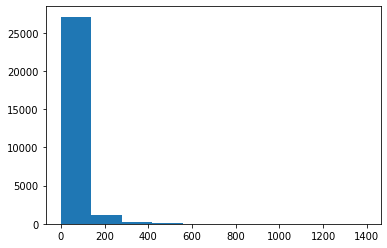

In [17]:
plt.hist([len(re.findall(r'\w+', i)) for i in test_arrs[0]])
plt.show()

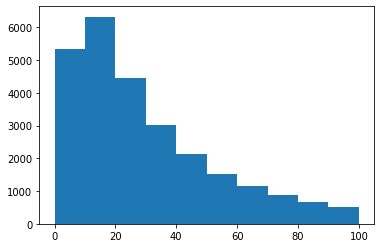

In [18]:
plt.hist([len(re.findall(r'\w+', i)) for i in test_arrs[0]], range = (0, 100))
plt.show()

In [21]:
for arr in test_arrs:
    print(sum([len(re.findall(r'\w+', i)) <= 10 for i in arr]) / len(arr))

0.2105318551782206
0.21925691822979154
0.27739582459964784
0.35248959290695786
0.2881875032036496
0.4296728635250036


In [22]:
for arr in test_arrs:
    print(sum([len(re.findall(r'\w+', i)) <= 30 for i in arr]) / len(arr))

0.5778838057816447
0.5849842468225402
0.6448394399262178
0.7251446180461697
0.6532369675534369
0.7933059518662632


In [17]:
def calculate_values_ind_l(text1, text2, scoring_func, length=10):
    scores1 = []
    scores2 = []
    
    for arr in text1:
        if len(arr) > 0:
            tmp = [' '.join(re.findall(r'\w+', i)[:length]) for i in arr if len(re.findall(r'\w+', i)) >= length]
            if len(tmp) > 0:
                scores1.append(np.mean([scoring_func(s, eos=False) for s in tmp]))
            
    for arr in text2:
        if len(arr) > 0:
            tmp = [' '.join(re.findall(r'\w+', i)[:length]) for i in arr if len(re.findall(r'\w+', i)) >= length]
            if len(tmp) > 0:
                scores2.append(np.mean([scoring_func(s, eos=False) for s in tmp]))

    mean1 = sum(scores1)/len(scores1)
    mean2 = sum(scores2)/len(scores2)
    print(mean1)
    print(mean2)
    print(len(scores1))
    print(len(scores2))
    print()
    
    print(ttest_ind(scores1, scores2))

In [18]:
def calculate_values_rel_l(text1, text2, scoring_func, length=10):
    scores1 = []
    scores2 = []
    
    for i in range(len(text1)):
        if len(text1[i]) > 0 and len(text2[i]) > 0:
            tmp1 = [' '.join(re.findall(r'\w+', i)[:length]) for i in text1[i] if len(re.findall(r'\w+', i)) >= length]
            tmp2 = [' '.join(re.findall(r'\w+', i)[:length]) for i in text2[i] if len(re.findall(r'\w+', i)) >= length]
            
            if len(tmp1) > 0 and len(tmp2) > 0:
                scores1.append(np.mean([scoring_func(s, eos=False) for s in tmp1]))
                scores2.append(np.mean([scoring_func(s, eos=False) for s in tmp2]))

    mean1 = sum(scores1)/len(scores1)
    mean2 = sum(scores2)/len(scores2)
    print(mean1)
    print(mean2)
    print(len(scores1))
    print(len(scores2))
    print()
    
    print(ttest_rel(scores1, scores2))

In [45]:
print("sfp_politics_before, td_politics_before, sfp_politics_before")
calculate_values_ind_l(test_arrs_u[0], test_arrs_u[2], language_models[1].score)

print("\nsfp_politics_before, td_politics_before, td_politics_before")
calculate_values_ind_l(test_arrs_u[0], test_arrs_u[2], language_models[3].score)

print("\nsfp_politics_after, td_politics_after, sfp_politics_after")
calculate_values_ind_l(test_arrs_u[1], test_arrs_u[3], language_models[2].score)

print("\nsfp_politics_after, td_politics_after, td_politics_after")
calculate_values_ind_l(test_arrs_u[1], test_arrs_u[3], language_models[4].score)

print("\nsfp_politics_before, td_politics_before, sfp_posts")
calculate_values_ind_l(test_arrs_u[0], test_arrs_u[2], language_models[5].score)

print("\nsfp_politics_before, td_politics_before, td_posts")
calculate_values_ind_l(test_arrs_u[0], test_arrs_u[2], language_models[6].score)

print("\nsfp_politics_after, td_politics_after, sfp_posts")
calculate_values_ind_l(test_arrs_u[1], test_arrs_u[3], language_models[5].score)

print("\nsfp_politics_after, td_politics_after, td_posts")
calculate_values_ind_l(test_arrs_u[1], test_arrs_u[3], language_models[6].score)

print("\nsfp_politics_before, td_politics_before, politics")
calculate_values_ind_l(test_arrs_u[0], test_arrs_u[2], language_models[0].score)

print("\nsfp_politics_after, td_politics_after, politics")
calculate_values_ind_l(test_arrs_u[1], test_arrs_u[3], language_models[0].score)

print("\nsfp_posts, td_posts, sfp_posts")
calculate_values_ind_l(test_arrs_u[4], test_arrs_u[5], language_models[5].score)

print("\nsfp_posts, td_posts, td_posts")
calculate_values_ind_l(test_arrs_u[4], test_arrs_u[5], language_models[6].score)

print("\nsfp_posts, td_posts, politics")
calculate_values_ind_l(test_arrs_u[4], test_arrs_u[5], language_models[0].score)

print("\nsfp_politics_before, sfp_politics_after, politics")
calculate_values_rel_l(test_arrs_u[0], test_arrs_u[1], language_models[0].score)

print("\nsfp_politics_before, sfp_politics_after, sfp_posts")
calculate_values_rel_l(test_arrs_u[0], test_arrs_u[1], language_models[5].score)

print("\nsfp_politics_before, sfp_posts, sfp_posts")
calculate_values_rel_l(test_arrs_u[0], test_arrs_u[4], language_models[5].score)

print("\nsfp_politics_after, sfp_posts, sfp_posts")
calculate_values_rel_l(test_arrs_u[1], test_arrs_u[4], language_models[5].score)

print("\ntd_politics_before, td_politics_after, politics")
calculate_values_rel_l(test_arrs_u[2], test_arrs_u[3], language_models[0].score)

print("\ntd_politics_before, td_politics_after, td_posts")
calculate_values_rel_l(test_arrs_u[2], test_arrs_u[3], language_models[6].score)

print("\ntd_politics_before, td_posts, td_posts")
calculate_values_rel_l(test_arrs_u[2], test_arrs_u[5], language_models[5].score)

print("\ntd_politics_after, td_posts, td_posts")
calculate_values_rel_l(test_arrs_u[3], test_arrs_u[5], language_models[5].score)

sfp_politics_before, td_politics_before, sfp_politics_before
-26.789264657267978
-27.250003299007734
873
775

Ttest_indResult(statistic=2.8900461563443143, pvalue=0.003902319748156859)

sfp_politics_before, td_politics_before, td_politics_before
-26.893727195075165
-27.267033848861747
873
775

Ttest_indResult(statistic=2.3520670521673552, pvalue=0.018786654736809346)

sfp_politics_after, td_politics_after, sfp_politics_after
-26.57888741672355
-27.07262788308709
1098
572

Ttest_indResult(statistic=3.1133273100230228, pvalue=0.0018813328245479793)

sfp_politics_after, td_politics_after, td_politics_after
-27.10678104492129
-27.449692949773404
1098
572

Ttest_indResult(statistic=2.2094084660856055, pvalue=0.027281677665053124)

sfp_politics_before, td_politics_before, sfp_posts
-27.058947844872076
-27.47784491564112
873
775

Ttest_indResult(statistic=2.5560908681051044, pvalue=0.010674673751404969)

sfp_politics_before, td_politics_before, td_posts
-27.362983251646316
-27.501246878914454

In [19]:
print("sfp_politics_before, td_politics_before, sfp_politics_before")
calculate_values_ind_l(test_arrs_u[0], test_arrs_u[2], language_models5[1].score)

print("\nsfp_politics_before, td_politics_before, td_politics_before")
calculate_values_ind_l(test_arrs_u[0], test_arrs_u[2], language_models5[3].score)

print("\nsfp_politics_after, td_politics_after, sfp_politics_after")
calculate_values_ind_l(test_arrs_u[1], test_arrs_u[3], language_models5[2].score)

print("\nsfp_politics_after, td_politics_after, td_politics_after")
calculate_values_ind_l(test_arrs_u[1], test_arrs_u[3], language_models5[4].score)

print("\nsfp_politics_before, td_politics_before, sfp_posts")
calculate_values_ind_l(test_arrs_u[0], test_arrs_u[2], language_models5[5].score)

print("\nsfp_politics_before, td_politics_before, td_posts")
calculate_values_ind_l(test_arrs_u[0], test_arrs_u[2], language_models5[6].score)

print("\nsfp_politics_after, td_politics_after, sfp_posts")
calculate_values_ind_l(test_arrs_u[1], test_arrs_u[3], language_models5[5].score)

print("\nsfp_politics_after, td_politics_after, td_posts")
calculate_values_ind_l(test_arrs_u[1], test_arrs_u[3], language_models5[6].score)

print("\nsfp_politics_before, td_politics_before, politics")
calculate_values_ind_l(test_arrs_u[0], test_arrs_u[2], language_models5[0].score)

print("\nsfp_politics_after, td_politics_after, politics")
calculate_values_ind_l(test_arrs_u[1], test_arrs_u[3], language_models5[0].score)

print("\nsfp_posts, td_posts, sfp_posts")
calculate_values_ind_l(test_arrs_u[4], test_arrs_u[5], language_models5[5].score)

print("\nsfp_posts, td_posts, td_posts")
calculate_values_ind_l(test_arrs_u[4], test_arrs_u[5], language_models5[6].score)

print("\nsfp_posts, td_posts, politics")
calculate_values_ind_l(test_arrs_u[4], test_arrs_u[5], language_models5[0].score)

print("\nsfp_politics_before, sfp_politics_after, politics")
calculate_values_rel_l(test_arrs_u[0], test_arrs_u[1], language_models5[0].score)

print("\nsfp_politics_before, sfp_politics_after, sfp_posts")
calculate_values_rel_l(test_arrs_u[0], test_arrs_u[1], language_models5[5].score)

print("\nsfp_politics_before, sfp_posts, sfp_posts")
calculate_values_rel_l(test_arrs_u[0], test_arrs_u[4], language_models5[5].score)

print("\nsfp_politics_after, sfp_posts, sfp_posts")
calculate_values_rel_l(test_arrs_u[1], test_arrs_u[4], language_models5[5].score)

print("\ntd_politics_before, td_politics_after, politics")
calculate_values_rel_l(test_arrs_u[2], test_arrs_u[3], language_models5[0].score)

print("\ntd_politics_before, td_politics_after, td_posts")
calculate_values_rel_l(test_arrs_u[2], test_arrs_u[3], language_models5[6].score)

print("\ntd_politics_before, td_posts, td_posts")
calculate_values_rel_l(test_arrs_u[2], test_arrs_u[5], language_models5[5].score)

print("\ntd_politics_after, td_posts, td_posts")
calculate_values_rel_l(test_arrs_u[3], test_arrs_u[5], language_models5[5].score)

sfp_politics_before, td_politics_before, sfp_politics_before
-25.938808419917407
-26.470183499344987
873
775

Ttest_indResult(statistic=3.0155949482813607, pvalue=0.0026040164109425844)

sfp_politics_before, td_politics_before, td_politics_before
-26.199743291767096
-26.59702527295056
873
775

Ttest_indResult(statistic=2.280301597804932, pvalue=0.02271717552737177)

sfp_politics_after, td_politics_after, sfp_politics_after
-25.77778968952965
-26.292930258026146
1098
572

Ttest_indResult(statistic=2.9524262242504875, pvalue=0.0031969419640390426)

sfp_politics_after, td_politics_after, td_politics_after
-26.629333034955902
-26.89883022612285
1098
572

Ttest_indResult(statistic=1.6402737833325156, pvalue=0.10113680364176883)

sfp_politics_before, td_politics_before, sfp_posts
-26.191260192030207
-26.614495047427642
873
775

Ttest_indResult(statistic=2.362275322726203, pvalue=0.018278952355122533)

sfp_politics_before, td_politics_before, td_posts
-26.558897380091626
-26.713236306306904
8